In [15]:
import numpy as np
import matplotlib.pyplot as plt
# from vis import plot_superadj
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI

In [16]:
import pickle as pkl

import networkx as nx
import numpy as np
import scipy.sparse as sp
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import sklearn.preprocessing as preprocess
import sys
def load_data(dataset_str): # {'pubmed', 'citeseer', 'cora'}
    """Load data."""

    if dataset_str == 'wiki':
        adj, features, label = load_wiki()
        return adj, features, label, 0, 0, 0

    elif dataset_str in ["cora", "citeseer", "pubmed"]:

        names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
        objects = []
        for i in range(len(names)):
            with open("/data/liuyue/New/AGE/data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
                if sys.version_info > (3, 0):
                    objects.append(pkl.load(f, encoding='latin1'))
                else:
                    objects.append(pkl.load(f))

        x, y, tx, ty, allx, ally, graph = tuple(objects)
        test_idx_reorder = parse_index_file("/data/liuyue/New/AGE/data/ind.{}.test.index".format(dataset_str))
        test_idx_range = np.sort(test_idx_reorder)

        if dataset_str == 'citeseer':
            # Fix citeseer dataset (there are some isolated nodes in the graph)
            # Find isolated nodes, add them as zero-vecs into the right position
            test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
            tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
            tx_extended[test_idx_range-min(test_idx_range), :] = tx
            tx = tx_extended
            ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
            ty_extended[test_idx_range-min(test_idx_range), :] = ty
            ty = ty_extended

        features = sp.vstack((allx, tx)).tolil()
        features[test_idx_reorder, :] = features[test_idx_range, :]
        adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

        labels = np.vstack((ally, ty))
        labels[test_idx_reorder, :] = labels[test_idx_range, :]

        idx_test = test_idx_range.tolist()
        idx_train = range(len(y))
        idx_val = range(len(y), len(y)+500)


        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.view(-1)
            else:
                labels = labels.argmax(1)

    elif dataset_str in ["amazon-photo", "amazon-computers"]:
        map2names = {
            "amazon-photo": "/data/liuyue/New/SBM/mySBM/data/amazon_electronics_photo.npz",
            "amazon-computers": "/data/liuyue/New/SBM/mySBM/data/amazon_electronics_computers.npz",
        }

        data = np.load(map2names[dataset_str])
        # print(list(data.keys()))
        adj_data, adj_indices, adj_indptr, adj_shape = data["adj_data"], data["adj_indices"], data["adj_indptr"], data["adj_shape"]
        attr_data, attr_indices, attr_indptr, attr_shape = data["attr_data"], data["attr_indices"], data["attr_indptr"], data["attr_shape"]
        labels = data["labels"]

        adj = sp.csr_matrix((adj_data, adj_indices, adj_indptr), shape=adj_shape).tocoo()
        features = sp.csr_matrix((attr_data, attr_indices, attr_indptr), shape=attr_shape).tocoo()

        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.reshape(-1)
            else:
                labels = labels.argmax(1)

        return adj, features, labels, 0, 0, 0

    return adj, features, labels, idx_train, idx_val, idx_test

def load_wiki():
    f = open('/data/liuyue/New/AGE/data/graph.txt','r')
    adj, xind, yind = [], [], []
    for line in f.readlines():
        line = line.split()
        
        xind.append(int(line[0]))
        yind.append(int(line[1]))
        adj.append([int(line[0]), int(line[1])])
    f.close()
    ##print(len(adj))

    f = open('/data/liuyue/New/AGE/data/group.txt','r')
    label = []
    for line in f.readlines():
        line = line.split()
        label.append(int(line[1]))
    f.close()

    f = open('/data/liuyue/New/AGE/data/tfidf.txt','r')
    fea_idx = []
    fea = []
    adj = np.array(adj)
    adj = np.vstack((adj, adj[:,[1,0]]))
    adj = np.unique(adj, axis=0)
    
    labelset = np.unique(label)
    labeldict = dict(zip(labelset, range(len(labelset))))
    label = np.array([labeldict[x] for x in label])
    adj = sp.csr_matrix((np.ones(len(adj)), (adj[:,0], adj[:,1])), shape=(len(label), len(label)))

    for line in f.readlines():
        line = line.split()
        fea_idx.append([int(line[0]), int(line[1])])
        fea.append(float(line[2]))
    f.close()

    fea_idx = np.array(fea_idx)
    features = sp.csr_matrix((fea, (fea_idx[:,0], fea_idx[:,1])), shape=(len(label), 4973)).toarray()
    scaler = preprocess.MinMaxScaler()
    #features = preprocess.normalize(features, norm='l2')
    features = scaler.fit_transform(features)
    features = torch.FloatTensor(features)

    return adj, features, label
def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

In [17]:
dataset = "pubmed"
seed = 0
edge_size = 10
adj, _, labels, _, _, _ = load_data(dataset)
nclass = np.unique(labels).shape[0]

In [18]:
n, m = adj.shape[0], adj.sum()
print(adj.shape[0], adj.sum())

19717 88651


In [19]:
from locale import normalize
import os
import time
import argparse
from turtle import pos
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from dgl import DGLGraph
import dgl.function as fn

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# torch.cuda.set_device(0)

import dgl
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import itertools
import scipy.sparse as sp

# csr_matrix: 行内indices动, data不动; 行间indices动, data动
# sparse_matrix: n * n
def reorder_sparse(sparse_matrix, new_idx):
    indices, indptr, data = sparse_matrix.indices, sparse_matrix.indptr, sparse_matrix.data
    n = sparse_matrix.shape[0]
    new_idx = np.array(new_idx)
    new_idx_s = np.argsort(new_idx)
    indices_l, data_l = [], []
    for i in range(n):
        indices_l.append(indices[indptr[i]:indptr[i+1]].tolist())
        data_l.append(data[indptr[i]:indptr[i+1]].tolist())
    # 先行内动
    for i in range(n):
        temp = [new_idx_s[j] for j in indices_l[i]]
        indices_l[i] = temp
    
    # 再行间动
    indices_l = [indices_l[i] for i in new_idx]
    data_l = [data_l[i] for i in new_idx]
    new_indptr = [0]
    for i in range(n):
        new_indptr.append(new_indptr[i]+len(indices_l[i]))
    new_indices = list(itertools.chain(*indices_l))
    new_data = list(itertools.chain(*data_l))

    ret = sp.csr_matrix((new_data, new_indices, new_indptr), shape=(n,n)).sorted_indices()
    return ret

def reorder_sparse_coo(sparse_matrix, new_idx):
    sparse_matrix = sparse_matrix.tocoo()
    row, col, data = sparse_matrix.row, sparse_matrix.col, sparse_matrix.data
    n = sparse_matrix.shape[0]
    new_idx = np.array(new_idx)
    new_idx_s = np.argsort(new_idx)

    row, col = new_idx_s[row], new_idx_s[col]

    return sp.coo_matrix((data, (row, col)), shape=(n,n))



def superPixels(adj, K=100, sparse=False):
    n = adj.shape[0]
    unit = n // K
    superadj = np.zeros((K, K))
    if not sparse:
        print("N sparse")
        for i in range(K):
            for j in range(K):
                temp = adj[(i*unit):min((i+1)*unit, n), (j*unit):min((j+1)*unit, n)]
                superadj[i, j] = temp.mean()
    else:
        adj = adj.tocsr()
        indices, indptr, data = adj.indices, adj.indptr, adj.data
        for i in tqdm(range(K), total=K):
            for j in range(K):
                row_min = i*unit
                row_max = min((i+1)*unit, n)
                col_min = j*unit
                col_max = min((j+1)*unit, n)
                
                temp = 0.

                for row in range(row_min, row_max):
                    indices_ = indices[indptr[row]:indptr[row+1]]
                    if len(indices_) > 0 and indices_[-1] >= col_min and indices_[0] < col_max:
                        st = np.searchsorted(indices_, col_min)
                        ed = np.searchsorted(indices_, col_max)
                        # st += indptr[row]
                        # ed += indptr[row]
                        # temp += data[st:ed].sum()
                        temp += ed - st
                        # for k in range(indptr[row], indptr[row+1]):
                        #     if indices[k] >= col_min and indices[k] < col_max:
                        #         temp += data[k]
                        #         cnt += 1

                temp /= (row_max - row_min) * (col_max - col_min)

                superadj[i, j] = temp
    return superadj

def plot_superadj(adj, K=100, sparse=True, labels=None, dataset="", folder=None, vline=False):
    print(123)

    if labels is not None:
        idx = np.argsort(labels, 0)
        if sparse:
            # adj = reorder_sparse(adj, idx)
            adj = reorder_sparse_coo(adj, idx)
        else:
            adj = adj[idx, :][:, idx]
    n = adj.shape[0]

    adj = superPixels(adj, K, sparse=sparse)
    plt.figure()
    ax = plt.gca()
    plt.imshow(adj, cmap="coolwarm")
    plt.colorbar()
    if labels is not None and vline:
        labels = np.array(labels, dtype=np.int)
        labels = np.sort(labels)
        minl, maxl = labels[0], labels[-1]
        xs = []
        for l in range(minl+1, maxl+1):
            idx = np.searchsorted(labels, l)
            xs.append(idx)
        unit = n // K
        xs = [x / unit for x in xs]
        for x in xs:
            plt.axvline(x=x, color="red")
    plt.clim(0.0, 1.0)

    if folder is None:
        os.makedirs("pics", exist_ok=True)
        plt.savefig("pics/adj_{}.png".format(dataset))
    else:
        os.makedirs("pics/{}".format(folder), exist_ok=True)
        plt.savefig("pics/{}/adj_{}.png".format(folder, dataset))


In [20]:
def louvain_cluster(adj, labels, random_state=None):
    from community import community_louvain, modularity
    import networkx as nx
    from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI

    graph = nx.from_scipy_sparse_matrix(adj)
    partition = community_louvain.best_partition(graph, random_state=random_state)
    preds = list(partition.values())
    
    mod = modularity(partition, graph)
    
    return preds, mod

In [21]:
def infomap_cluster(adj, labels, random_state=None):
    graph = nx.from_scipy_sparse_matrix(adj)
    
    from infomap import Infomap
    im = Infomap(silent=True)
    mapping = im.add_networkx_graph(graph)
    im.run()
    partition = im.get_dataframe(columns=["node_id", "module_id"])
    partition = partition.sort_values(by="node_id")
    preds = partition["module_id"].tolist()
    
#     print(partition)
#     print(preds)
    
    return preds

In [22]:
def degin_degout(adj, labels):
    adj = adj.toarray()
    nclass = np.unique(labels).shape[0]
    
    ret = []
    for cls_id in range(nclass):
        node_ids = np.where(labels == cls_id)[0]
        
        sub_adj = adj[node_ids, :][:, node_ids]
        degin = sub_adj.sum()
        degout = adj[node_ids, :].sum() - degin
        
        ret.append(degin / degout)
        
    return ret

In [23]:
def pred2adj(preds, nclass=7):
    preds = np.array(preds)
    n = preds.shape[0]
    adj = np.zeros((n,n))
    
    for cls_id in range(nclass):
        node_ids = np.where(preds == cls_id)[0]
        
        mask1 = np.zeros((n,n))
        mask1[node_ids, :] = 1
        mask2 = np.zeros((n,n))
        mask2[:, node_ids] = 1
        
        adj = adj + mask1 * mask2
    
    adj = sp.coo_matrix(adj)
    return adj

## Baseline: KNN

In [24]:
data = np.load("/data/liuyue/New/SBM/mySBM/baselines/KNN/outputs/knn_adj_{}_{}_{:.1f}.npz".format(dataset, seed, edge_size))
adj_data, adj_row, adj_col = data["data"], data["row"], data["col"]
adj_s = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(n,n))
print(adj_s.shape[0], adj_s.sum())

19717 838830.44


In [25]:
deg_rates = degin_degout(adj_s, labels)

In [26]:
print(deg_rates)

[3.9481778, 4.923112, 3.7173252]


123


100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


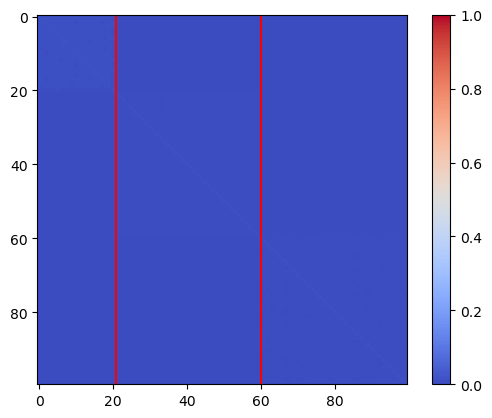

In [27]:
plot_superadj(adj_s, K=min(100,n), sparse=True, labels=labels, dataset="KNN_{}_{}_{:.1f}".format(dataset, seed, edge_size), vline=True)

In [28]:
preds, mod = louvain_cluster(adj_s, labels, random_state=seed)
nmi = NMI(labels, preds)
ami = AMI(labels, preds)
ari = ARI(labels, preds)

In [29]:
print(nmi, ami, ari, mod)

0.2644874487230773 0.26406997912200403 0.09766897725532518 0.8469098727020962


In [30]:
adj_s = pred2adj(preds, nclass=nclass)

123


100%|██████████| 100/100 [00:03<00:00, 32.25it/s]


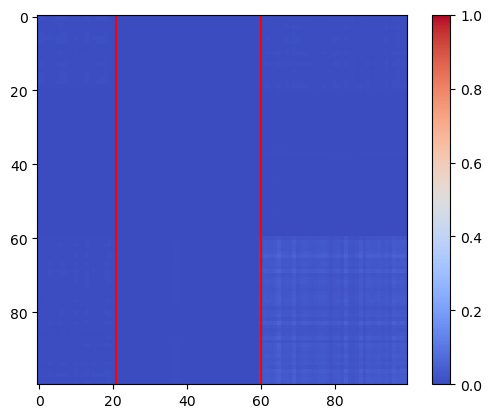

In [31]:
plot_superadj(adj_s, K=min(100,n), sparse=True, labels=labels, dataset="KNN_{}_{}_{:.1f}".format(dataset, seed, edge_size), vline=True)

In [32]:
adj_data = np.ones_like(adj_data)
adj_s = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(n,n))
print(adj_s.shape[0], adj_s.sum())

19717 906982.0


123


100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


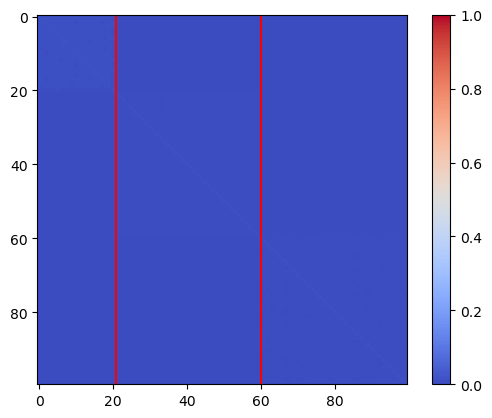

In [33]:
plot_superadj(adj_s, K=min(100,n), sparse=True, labels=labels, dataset="KNN_{}_{}_{:.1f}".format(dataset, seed, edge_size), vline=True)

In [34]:
preds, mod = louvain_cluster(adj_s, labels, random_state=seed)
nmi = NMI(labels, preds)
ami = AMI(labels, preds)
ari = ARI(labels, preds)

In [35]:
print(nmi, ami, ari, mod)

0.2665640833244973 0.26616149616690604 0.10183874161638526 0.8404801630671005


In [36]:
adj_s = pred2adj(preds, nclass)

123


100%|██████████| 100/100 [00:04<00:00, 21.88it/s]


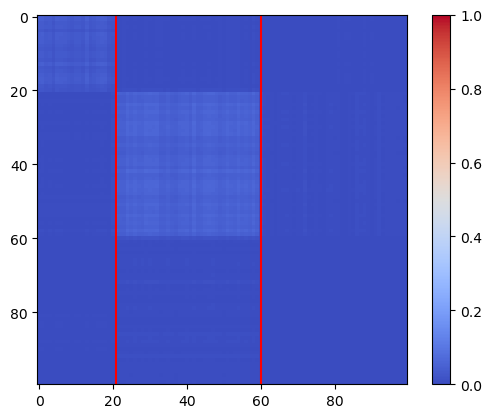

In [37]:
plot_superadj(adj_s, K=min(100,n), sparse=True, labels=labels, dataset="KNN_{}_{}_{:.1f}".format(dataset, seed, edge_size), vline=True)

## DLouvain-KNN

In [38]:
data = np.load("/data/liuyue/New/SBM/mySBM/link_adj_knn/GRACE/{}_{}.npz".format(dataset, seed))
adj_data, adj_row, adj_col = data["data"], data["row"], data["col"]
adj_s = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(n,n))

In [39]:
def sampling(adj, rate=0.5, random_state=None):
    if rate >= 1.0:
        return adj

    n = adj.shape[0]
    adj = adj.toarray()
    
    ret = np.zeros((n,n))
    
    for i in range(n):
        row_idx = adj[i].nonzero()[0]
        arr = np.random.RandomState(seed=random_state).choice(row_idx, int(rate*row_idx.shape[0]), replace=False)
        ret[i][arr] = 1
    
    return sp.coo_matrix(ret)

In [40]:
adj_s = sampling(adj_s, rate=10*m/adj_s.sum(), random_state=seed)
print(adj_s.shape[0], adj_s.sum())

19717 876687.0


In [41]:
deg_rates = degin_degout(adj_s, labels)

In [42]:
print(deg_rates)

[2.3470556106244818, 3.545067396475433, 2.8818645953788753]


123


100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


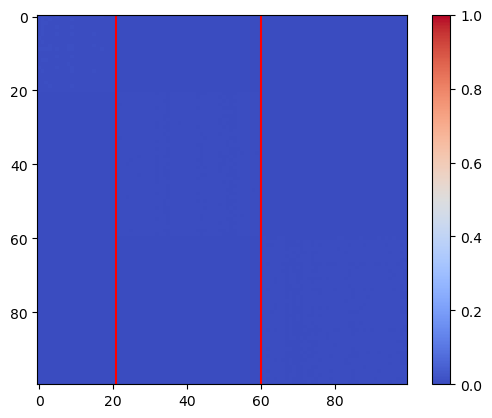

In [43]:
plot_superadj(adj_s, K=min(100,n), sparse=True, labels=labels, dataset="DLKNN_{}_{}_{:.1f}".format(dataset, seed, edge_size), vline=True)

In [44]:
preds, mod = louvain_cluster(adj_s, labels, random_state=seed)
nmi = NMI(labels, preds)
ami = AMI(labels, preds)
ari = ARI(labels, preds)

In [45]:
print(nmi, ami, ari, mod)

0.2754676761395698 0.27526564082352756 0.15182275688586372 0.7056247291797938


In [46]:
adj_s = pred2adj(preds, nclass)

123


100%|██████████| 100/100 [00:07<00:00, 13.89it/s]


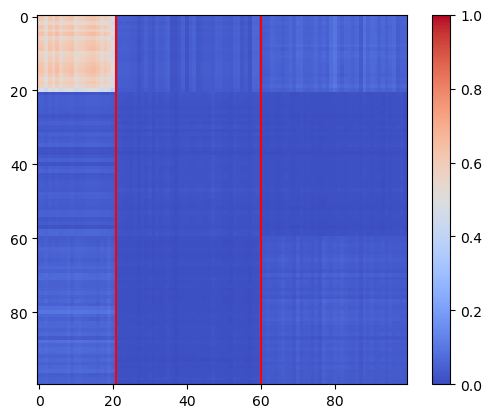

In [47]:
plot_superadj(adj_s, K=min(100,n), sparse=True, labels=labels, dataset="DLKNN_{}_{}_{:.1f}".format(dataset, seed, edge_size), vline=True)

## Infomap KNN

In [48]:
data = np.load("/data/liuyue/New/SBM/mySBM/baselines/KNN/outputs/knn_adj_{}_{}_{:.1f}.npz".format(dataset, seed, edge_size))
adj_data, adj_row, adj_col = data["data"], data["row"], data["col"]
adj_s = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(n,n))
print(adj_s.shape[0], adj_s.sum())

19717 838830.44


In [49]:
preds = infomap_cluster(adj_s, labels, random_state=seed)
nmi = NMI(labels, preds)
ami = AMI(labels, preds)
ari = ARI(labels, preds)

In [50]:
print(nmi, ami, ari)

0.18670492182960166 0.18665330577782113 0.1175822376385013


In [51]:
adj_s = pred2adj(preds, nclass=nclass)

123


100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


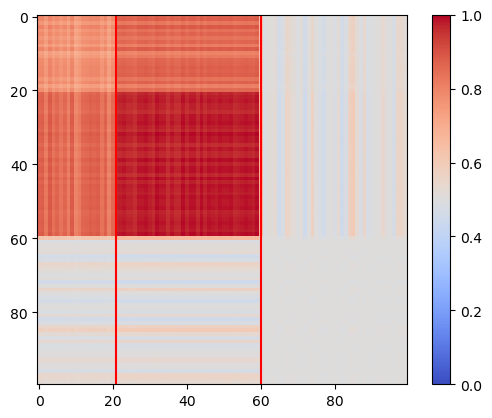

In [52]:
plot_superadj(adj_s, K=min(100,n), sparse=True, labels=labels, dataset="KNN_{}_{}_{:.1f}".format(dataset, seed, edge_size), vline=True)

In [53]:
adj_data = np.ones_like(adj_data)
adj_s = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(n,n))
print(adj_s.shape[0], adj_s.sum())

19717 906982.0


In [54]:
preds = infomap_cluster(adj_s, labels, random_state=seed)
nmi = NMI(labels, preds)
ami = AMI(labels, preds)
ari = ARI(labels, preds)

In [55]:
print(nmi, ami, ari)

0.3149632875139026 0.3148203353319719 0.24345302882547196


In [56]:
adj_s = pred2adj(preds, nclass=nclass)

123


100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


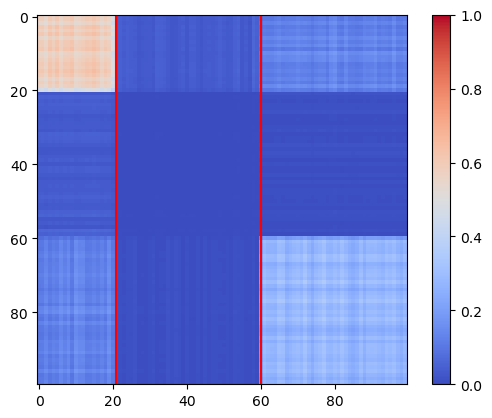

In [57]:
plot_superadj(adj_s, K=min(100,n), sparse=True, labels=labels, dataset="KNN_{}_{}_{:.1f}".format(dataset, seed, edge_size), vline=True)

## Infomap DLouvain-KNN

In [58]:
data = np.load("/data/liuyue/New/SBM/mySBM/link_adj_knn/GRACE/{}_{}.npz".format(dataset, seed))
adj_data, adj_row, adj_col = data["data"], data["row"], data["col"]
adj_s = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(n,n))

In [59]:
adj_s = sampling(adj_s, rate=10*m/adj_s.sum(), random_state=seed)
print(adj_s.shape[0], adj_s.sum())

19717 876687.0


In [60]:
preds = infomap_cluster(adj_s, labels, random_state=seed)
nmi = NMI(labels, preds)
ami = AMI(labels, preds)
ari = ARI(labels, preds)

In [61]:
print(nmi, ami, ari)

0.1983652924299491 0.1983152350988477 0.14168570364729516


In [62]:
adj_s = pred2adj(preds, nclass=nclass)

123


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


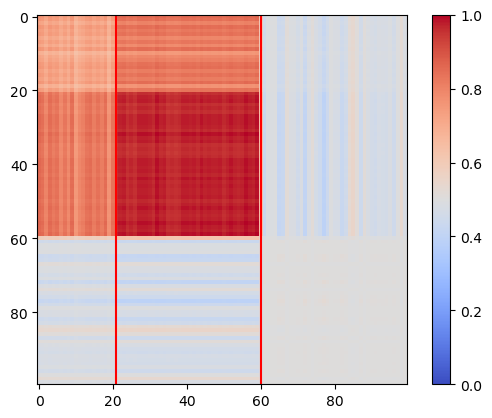

In [63]:
plot_superadj(adj_s, K=min(100,n), sparse=True, labels=labels, dataset="KNN_{}_{}_{:.1f}".format(dataset, seed, edge_size), vline=True)